In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import plotnine as p9

In [2]:
from adjustText import adjust_text

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype']='none' 

In [4]:
p9.options.dpi=300

In [5]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=300)

In [7]:
GEX_adata=sc.read_h5ad(D20data_dir+'/AggD20_GEX_Lineage_raw.h5ad')
#This anndata has been normalized and log1p, and saved in raw

In [8]:
fc_lineage=pd.read_csv(D0data_dir+'/D0toD20_lineage_change.csv',header=0)

In [9]:
fc_lineage['fc_category']=''
fc_lineage.loc[(fc_lineage['T0oak1to20_NumCells']>9) & (fc_lineage['fc_D20overD0']<0.4),'fc_category']='Most_depleted'
fc_lineage.loc[(fc_lineage['T0oak1to20_NumCells']>9) & (fc_lineage['fc_D20overD0']>9),'fc_category']='Most_enriched'

In [10]:
lineage_order_plot=fc_lineage[(fc_lineage.fc_category!='') & (fc_lineage.D20_NumCells>0)].sort_values(by='fc_D20overD0',ascending=True).sort_values(by='fc_D20overD0',ascending=True).LineageID

In [11]:
GEX_adata.obs=GEX_adata.obs.reset_index().merge(fc_lineage,how="left",left_on=['feature_call'],right_on=['LineageID']).set_index('index')

In [12]:
GEX_adata_2ends = GEX_adata[GEX_adata.obs['fc_category'].isin(['Most_enriched','Most_depleted']),:]

In [13]:
sc.tl.rank_genes_groups(GEX_adata_2ends, 'fc_category', method='wilcoxon')


/gstore/home/wub31/.conda/envs/py38_Scanpy_expanded/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
/gstore/home/wub31/.conda/envs/py38_Scanpy_expanded/lib/python3.8/site-packages/anndata/_core/anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'feature_call' as categorical
/gstore/home/wub31/.conda/envs/py38_Scanpy_expanded/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
Trying to set attribute `.obs` of view, copying.
... storing 'LineageID' as categorical
/gstore/home/wub31/.conda/

In [ ]:
GEX_adata_2ends.write(D20data_dir+'/AggD20_2ends.h5ad')

In [14]:
cluster_compare = GEX_adata_2ends.uns['rank_genes_groups']
groups = cluster_compare['names'].dtype.names
df_cluster_compare=pd.DataFrame(
    {group + '_' + key[:1]: cluster_compare[key][group]
    for group in groups for key in ['names','pvals_adj','logfoldchanges']})
#the logfoldchanges are log2
#use the p values that are adjusted

In [15]:
df_DE_plot=df_cluster_compare[['Most_enriched_n','Most_enriched_p','Most_enriched_l']]

In [16]:
df_DE_plot['-log10_p_adj']=-np.log10(df_DE_plot['Most_enriched_p'])

/local/15703663/ipykernel_23044/1476360735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
LabelList=(df_DE_plot[((df_DE_plot['-log10_p_adj']>8)&(df_DE_plot['Most_enriched_l']<-0.5)) | ((df_DE_plot['-log10_p_adj']>8)&(df_DE_plot['Most_enriched_l']>0.5))].Most_enriched_n).tolist()

In [18]:
df_DE_plot['GOI']=[x in LabelList for x in df_DE_plot.Most_enriched_n]

/local/15703663/ipykernel_23044/2100581794.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
df_DE_plot['point_color']=['High_enriched' if (x.GOI==True)&(x.Most_enriched_l>0) \
                          else 'High_depleted' if (x.GOI==True)&(x.Most_enriched_l<0) \
                          else 'Others' for index, x in df_DE_plot.iterrows()]

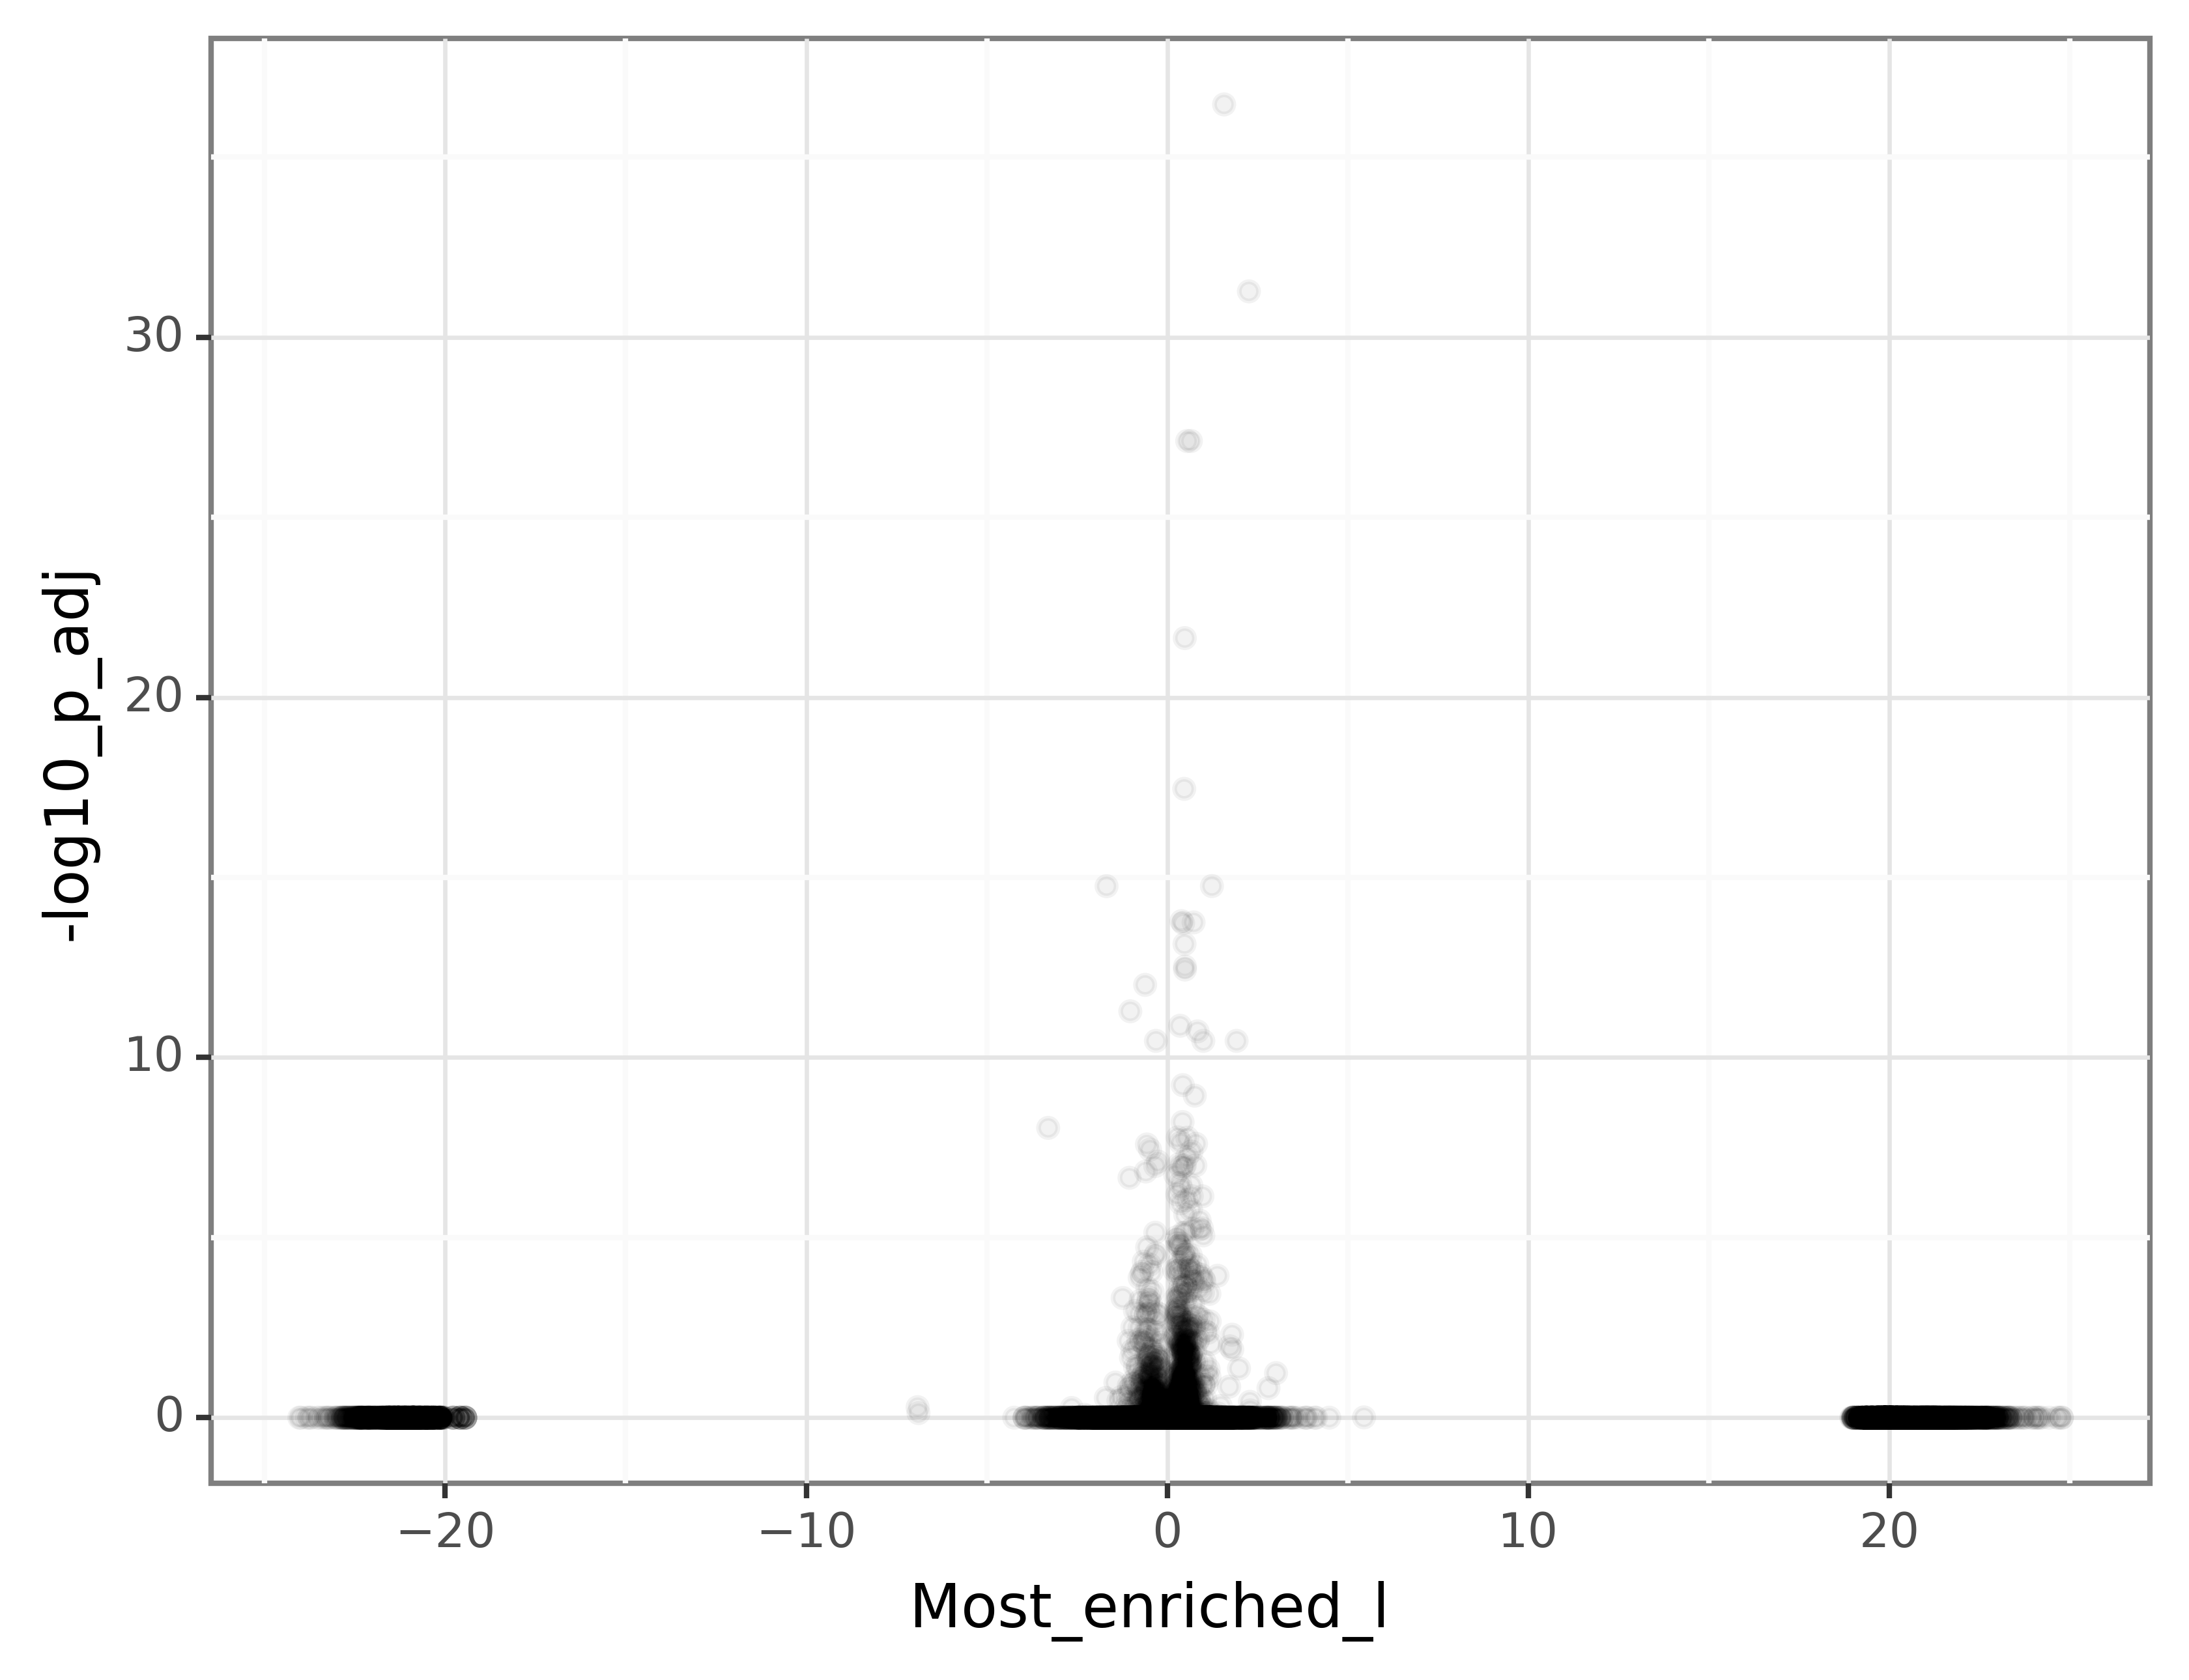

<ggplot: (2932155165672)>

In [20]:
plot = p9.ggplot(data=df_DE_plot,
                mapping=p9.aes(x='Most_enriched_l',y='-log10_p_adj'))
plot+ p9.themes.theme_bw() \
    + p9.geom_point(alpha = 0.05) 

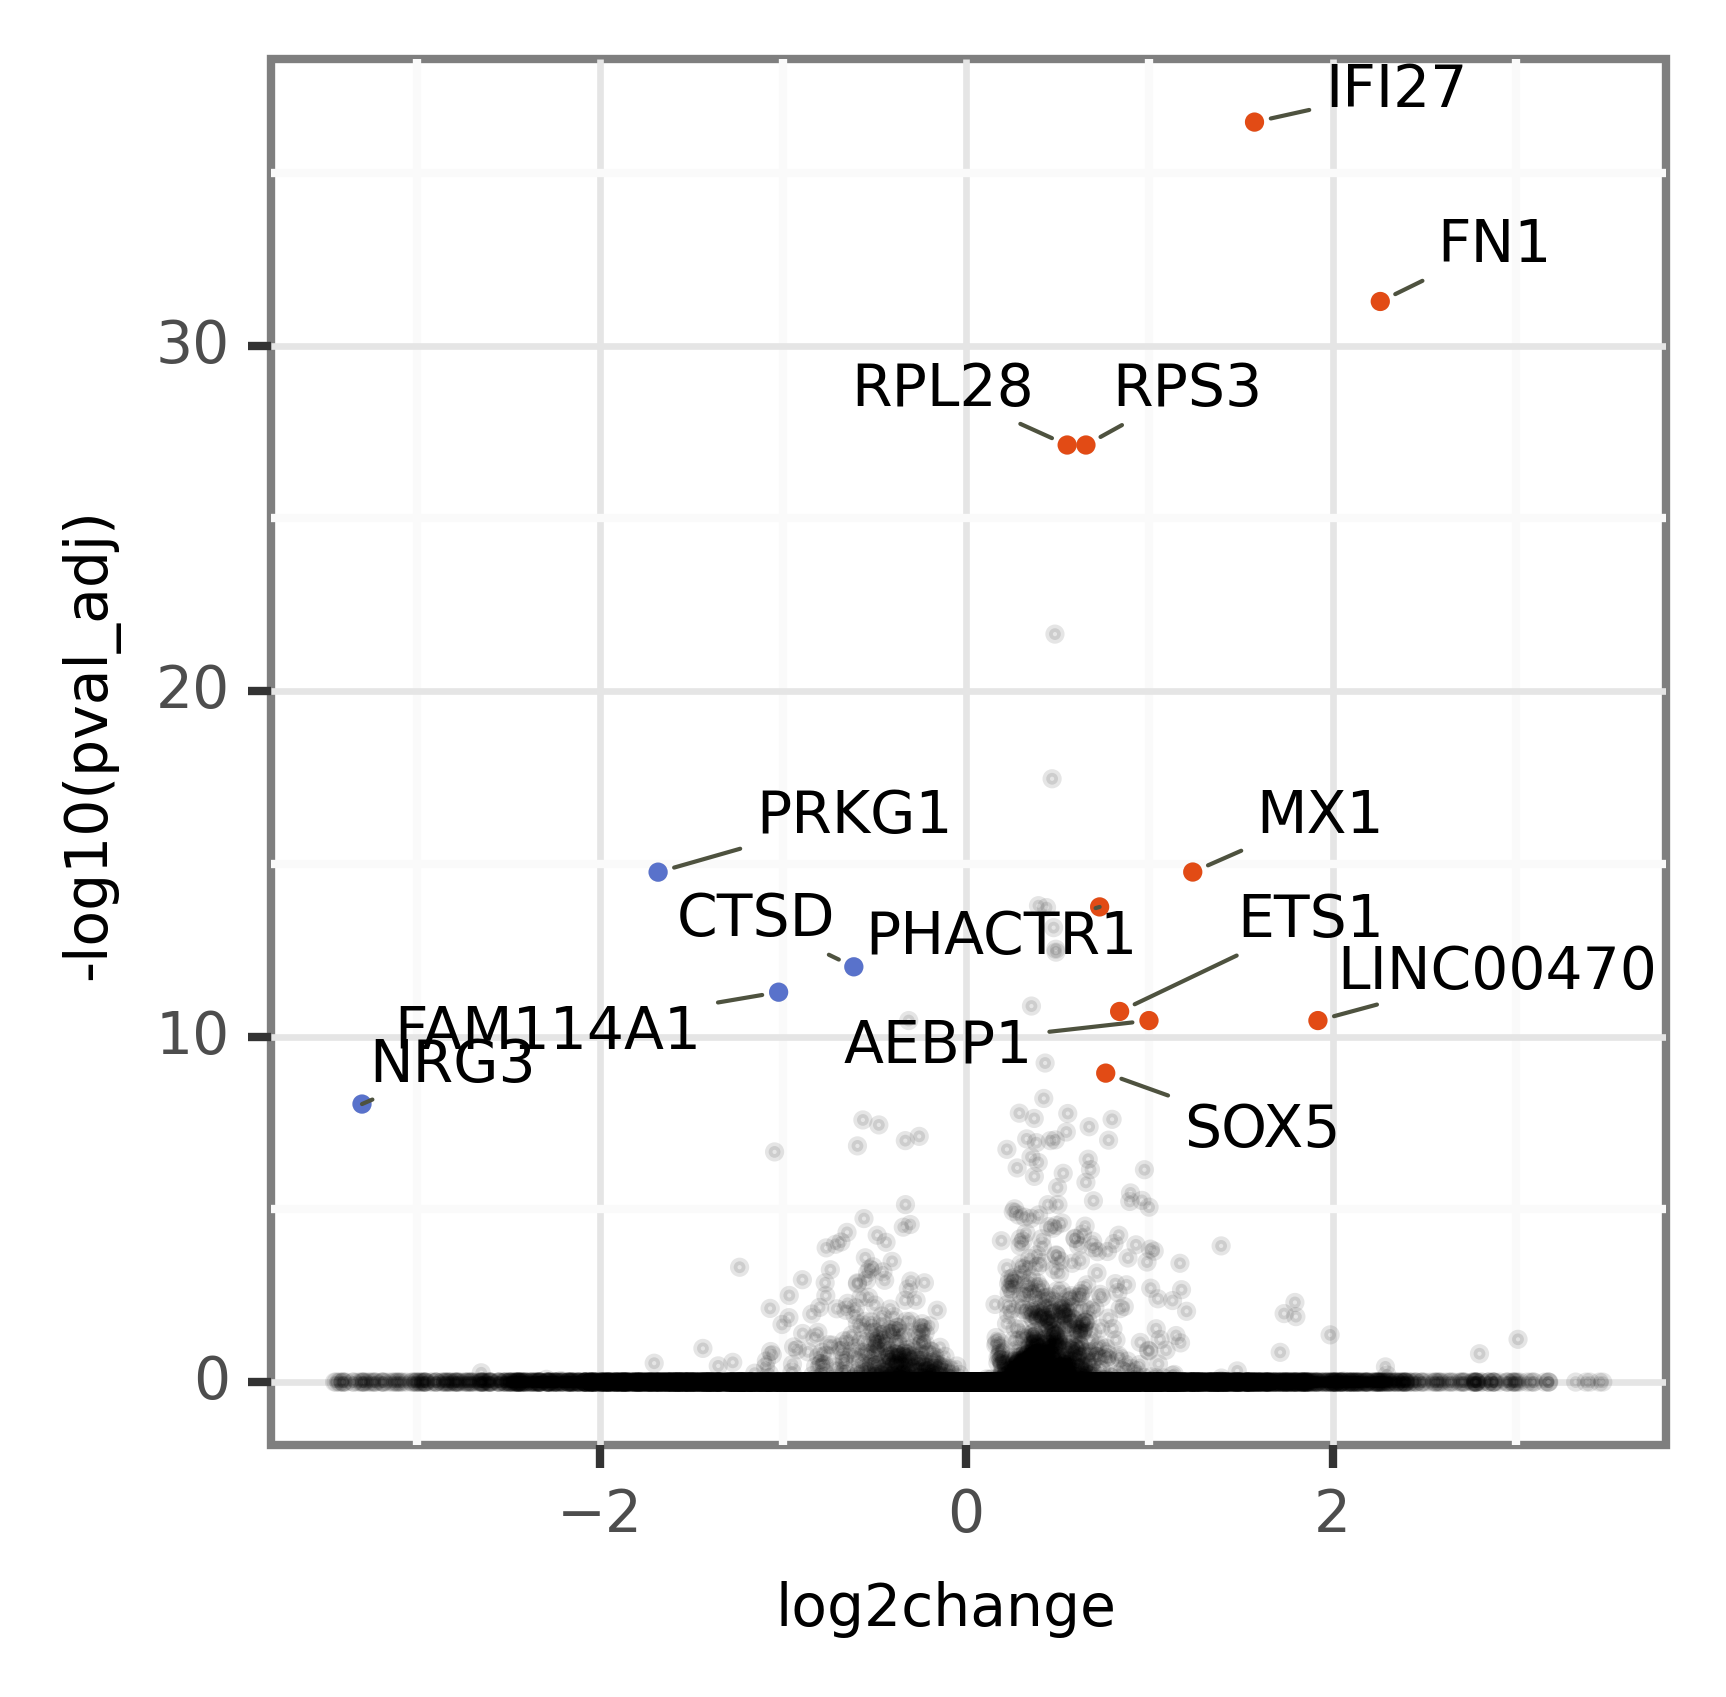

<ggplot: (2932155218676)>

In [21]:
adjust_text_dict = {
    'expand_points': (2, 2),
    'arrowprops': {
        'arrowstyle': '-',
        'color':'#4E523F',
        'lw':0.5
    }
}
plot = p9.ggplot(data=df_DE_plot[(df_DE_plot.Most_enriched_l<3.5) & (df_DE_plot.Most_enriched_l>-3.5)],
                mapping=p9.aes(x='Most_enriched_l',y='-log10_p_adj'))
plot+ p9.themes.theme_bw() \
    + p9.geom_point(alpha=0.1,size=0.3) \
    + p9.geom_point(data=df_DE_plot[df_DE_plot.GOI==True],mapping=p9.aes(color='point_color'),size=0.3) \
    + p9.scale_color_manual(values = {'Others':'#4E523F','High_enriched':'#E24B15','High_depleted':'#5972CB'}) \
    + p9.geom_text(data=df_DE_plot[df_DE_plot.GOI==True],mapping=p9.aes(x='Most_enriched_l',y='-log10_p_adj',label='Most_enriched_n'),size=7,adjust_text=adjust_text_dict) \
    + p9.ylab('-log10(pval_adj)') \
    + p9.xlab('log2change') \
    + p9.theme(text=p9.element_text(size=7),legend_position = 'none') \
    + p9.theme(figure_size=(3,3))


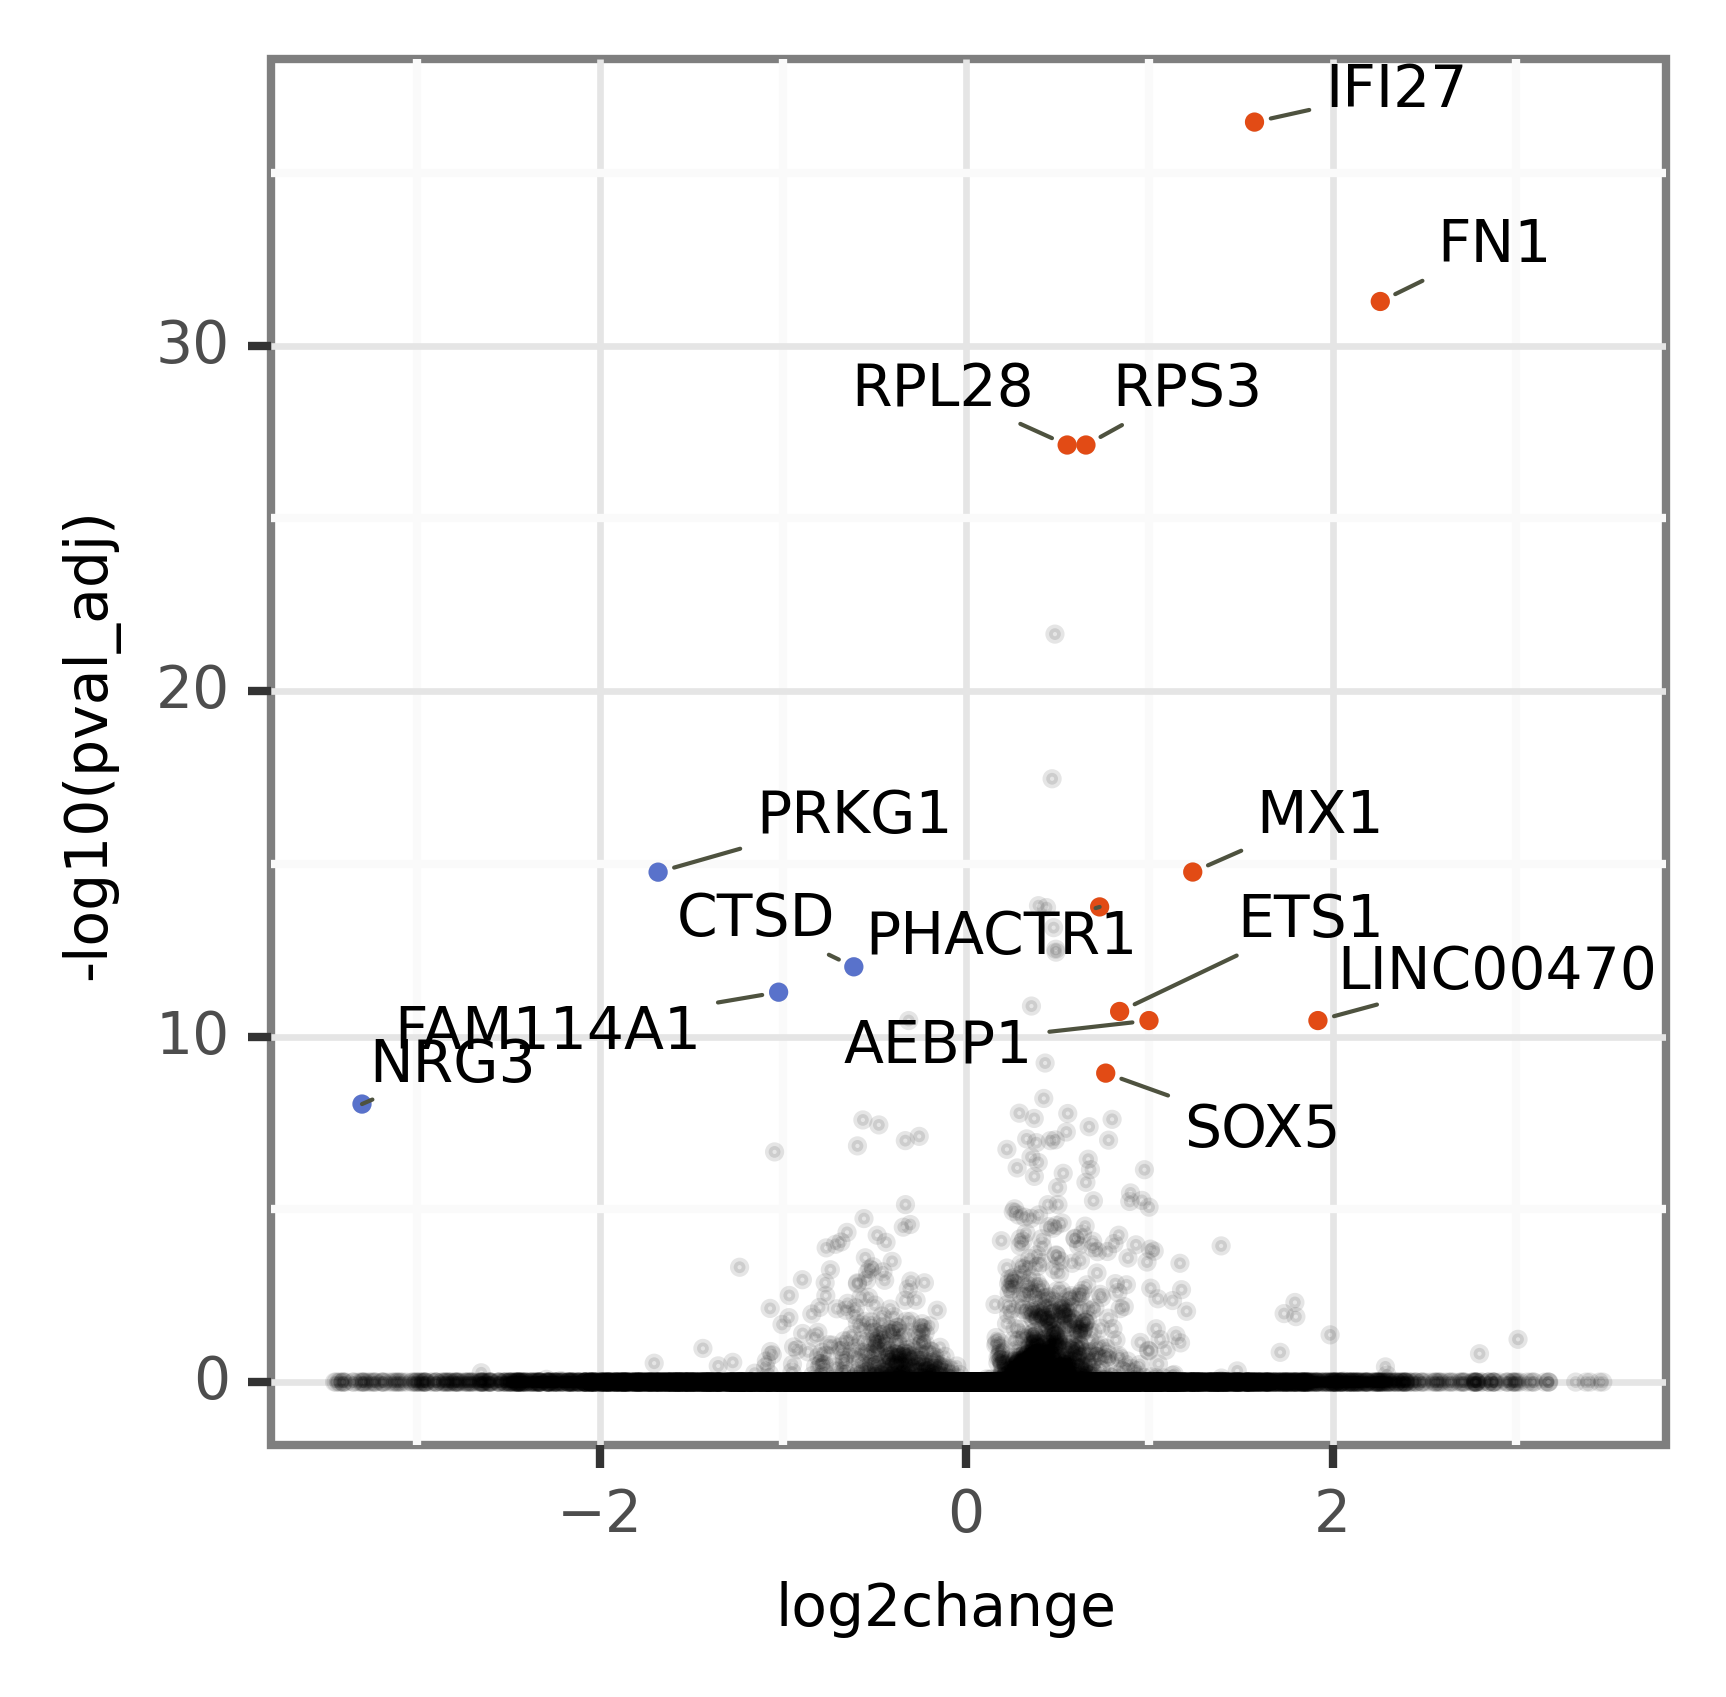

In [25]:
adjust_text_dict = {
    'expand_points': (2, 2),
    'arrowprops': {
        'arrowstyle': '-',
        'color':'#4E523F',
        'lw':0.5
    }
}
plot = p9.ggplot(data=df_DE_plot[(df_DE_plot.Most_enriched_l<3.5) & (df_DE_plot.Most_enriched_l>-3.5)],
                mapping=p9.aes(x='Most_enriched_l',y='-log10_p_adj'))
plotsave=plot+ p9.themes.theme_bw() \
    + p9.geom_point(alpha=0.1,size=0.3) \
    + p9.geom_point(data=df_DE_plot[df_DE_plot.GOI==True],mapping=p9.aes(color='point_color'),size=0.3) \
    + p9.scale_color_manual(values = {'Others':'#4E523F','High_enriched':'#E24B15','High_depleted':'#5972CB'}) \
    + p9.geom_text(data=df_DE_plot[df_DE_plot.GOI==True],mapping=p9.aes(x='Most_enriched_l',y='-log10_p_adj',label='Most_enriched_n'),size=7,adjust_text=adjust_text_dict) \
    + p9.ylab('-log10(pval_adj)') \
    + p9.xlab('log2change') \
    + p9.theme(text=p9.element_text(size=7),legend_position = 'none') \
    + p9.theme(figure_size=(3,3))
fig=plotsave.draw()
points = fig.axes[0].collections[0]
points.set_rasterized(True)
fig.savefig('D20Volcano_RasterPt.svg',format='svg',dpi=300)  
#rasterize the points while the rest of the plot stays vectorized. otherwise the svg file will be too large.